In [1]:
using LinearAlgebra, Random, Distributions, DynamicalSystems,  Plots
import Distributions: Uniform 

In [2]:
function kronecker_δ(i,j)
    if i == j
        return 1
    else
        return 0
    end
end

kronecker_δ(0,2)

0

In [3]:
function make_weight_matrix(g, N)
    dist = Normal(0, g^2/N)
    J = rand(dist, (N,N))
    return J - Diagonal(J)
end

make_weight_matrix(0.9, 4)

4×4 Array{Float64,2}:
 0.0       0.25636     0.0286009  -0.0997403
 0.706657  0.0        -0.100696    0.00264854
 0.346361  0.245008    0.0         0.0637921
 0.222089  0.0108609   0.428866    0.0

In [4]:
function instantaneous_jacobian(J,h)
    N = size(J)[1]
    output = zeros(N,N)
    for i = 1:N
        for j = 1:N
            output[i,j] = -kronecker_δ(i,j) + J[i,j]*sech(h[j])^2
        end
    end
    return output
end

J = make_weight_matrix(1,5)
h = rand(5)
instantaneous_jacobian(J,h)


5×5 Array{Float64,2}:
 -1.0         -0.12591     0.0483541   0.0402593  -0.120178
  0.0740305   -1.0         0.0924681  -0.104795    0.0149532
  0.00877691  -0.0118215  -1.0        -0.0385702  -0.358867
 -0.00225556  -0.111903    0.13304    -1.0         0.0252987
 -0.00796247  -0.180816   -0.0302576  -0.0592199  -1.0

In [41]:
for i = 10-1:-1:1
    print(i)
end

987654321

In [6]:
@inline @inbounds function engelken_tanh_model(u, p, t)
    J = p[1];
    
    # We need to first make W
    
    N = size(J)[1]
    
    du = []
    for i = 1:N
        argument = -u[i]
        for j = 1:N
            argument = argument + J[i,j]*tanh(u[j])
        end
        du = [du; argument]
    end

    
    return SVector{N}(du)
end

engelken_tanh_model (generic function with 1 method)

In [14]:
N = 20
g = 10
Random.seed!(40);
J = make_weight_matrix(g, N)
x0 = rand(Uniform(-1,1),N)

ds = ContinuousDynamicalSystem(engelken_tanh_model, x0, [J])

20-dimensional continuous dynamical system
 state:       [-0.559729, -0.711314, -0.729685, …, 0.999089, -0.289089]
 rule f:      engelken_tanh_model
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [[0.0 0.652489 … 13.3829 -0.456177; 12.3713 0.0 … 5.90812 6.50572; … ; -0.383054 -1.45316 … 0.0 2.6182; 3.31841 -0.521546 … 4.88728 0.0]]


In [18]:
tr = trajectory(ds, 100)

20-dimensional Dataset{Float64} with 10001 points
 -0.559729  -0.711314  -0.729685   …   0.661718     0.999089   -0.289089
 -0.720005  -0.673199  -0.635823       0.664394     0.90171    -0.388647
 -0.867886  -0.638056  -0.533315       0.657913     0.788105   -0.497557
 -1.00261   -0.605595  -0.426281       0.64057      0.656672   -0.616653
 -1.12387   -0.576183  -0.31859        0.610452     0.506323   -0.747193
 -1.23175   -0.550885  -0.213878   …   0.565558     0.336636   -0.890882
 -1.3266    -0.531448  -0.115505       0.504        0.148092   -1.04976
 -1.40896   -0.520216  -0.0263851      0.424302    -0.0577069  -1.22591
 -1.47934   -0.519982   0.0513038      0.325771    -0.277993   -1.42101
 -1.53806   -0.533786   0.116395       0.208759    -0.509061   -1.63594
 -1.58505   -0.564665   0.168852   …   0.0745932   -0.746809   -1.87073
 -1.6196    -0.615388   0.209697      -0.0749045   -0.987423   -2.12472
 -1.64021   -0.688288   0.240834      -0.238092    -1.22792    -2.39686
  ⋮     

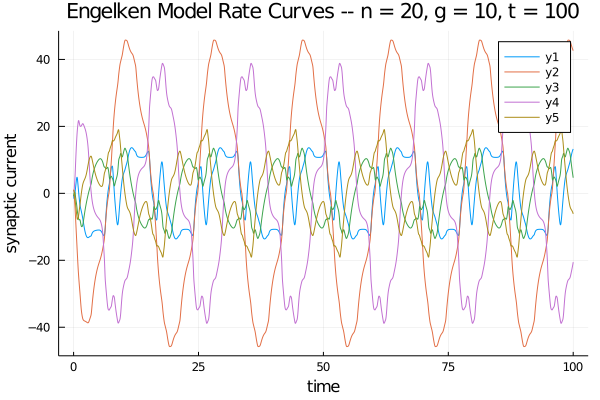

In [90]:
t = [0:0.01:100;]
plot(t,tr[:,1],
    title="Engelken Model Rate Curves -- n = 20, g = 10, t = 100",
    xlabel = "time",
    ylabel = "synaptic current")
plot!(t,tr[:,2])
plot!(t,tr[:,3])
plot!(t,tr[:,4])
plot!(t,tr[:,5])

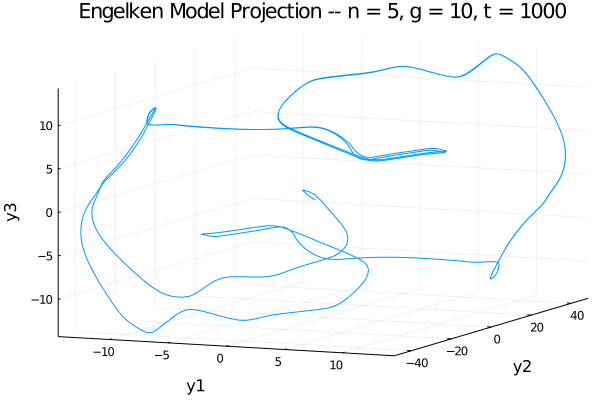

In [22]:
plot(tr[:, 1], tr[:, 2],tr[:, 3], 
    leg=false,
    title="Engelken Model Projection -- n = 5, g = 10, t = 1000",
    xlabel="y1",
    ylabel="y2",
    zlabel="y3")

In [25]:
lyaps = lyapunovs(ds,1000)

20-element Array{Float64,1}:
  0.0012189614414176541
 -0.4953806188972733
 -0.598811482415227
 -0.7358412257328925
 -0.8136975942669658
 -0.859968566180418
 -1.0061520190513633
 -1.009101350827381
 -1.0105446996978995
 -1.0293335133000199
 -1.0458655899441407
 -1.0476583123327012
 -1.0509374805140943
 -1.0570955748207431
 -1.1369472638671372
 -1.1379760848775269
 -1.1843779420875886
 -1.3816016449177146
 -1.3823645346068782
 -2.0175634923746135

In [125]:
sort(lyaps)

20-element Array{Float64,1}:
 -2.0175634923746135
 -1.3823645346068782
 -1.3816016449177146
 -1.1843779420875886
 -1.1379760848775269
 -1.1369472638671372
 -1.0570955748207431
 -1.0509374805140943
 -1.0476583123327012
 -1.0458655899441407
 -1.0293335133000199
 -1.0105446996978995
 -1.009101350827381
 -1.0061520190513633
 -0.859968566180418
 -0.8136975942669658
 -0.7358412257328925
 -0.598811482415227
 -0.4953806188972733
  0.0012189614414176541

In [128]:
time_back = 100

function oseledet_matrix(series, J)
    # input sampled trajectory
    t = size(series)[1]
    N = size(series)[2]
    T_t = instantaneous_jacobian(J, series[t,:])
    for i = (t-1):-1:1
        T_t = T_t*instantaneous_jacobian(J, series[i,:])
    end
    return T_t
end

T = oseledet_matrix(tr[end-time_back:end,:],J)
TstarT = transpose(T)*T
TstarT = TstarT^(1/(2time_back))

SVs = eigvals(TstarT)
# TstarT = oseledet_matrix(tr[end-time_back:end,:],J)

# SVs = svd(TstarT).S
osel = []
for x = SVs
    osel = [osel; (1/time_back)*log(x)]
end
sort(osel)

20-element Array{Any,1}:
 -0.000432222643717212
 -0.0002140817142021243
 -9.730342513290517e-5
 -4.4845755933699394e-5
 -1.3736552759427044e-6
 -4.771931889912998e-7
 -2.1679036697952968e-7
 -3.4580651548377604e-9
 -2.301861572309852e-10
 -3.924738763913141e-11
 -2.6342128481987673e-12
  1.2230216839263247e-14
  4.974465284123103e-14
  7.806658148293862e-10
  4.454458753396225e-9
  5.016867223584221e-7
  6.645067205290069e-5
  0.00011612241390935372
  0.0011767849795790823
  0.0017078861568374322

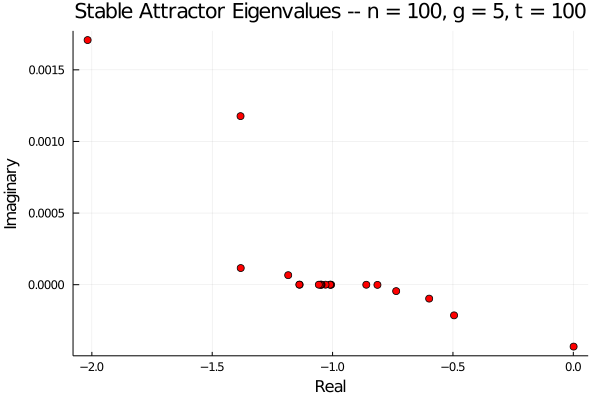

In [129]:
plot(lyaps, osel,    seriestype = :scatter, 
    title = "Stable Attractor Eigenvalues -- n = 100, g = 5, t = 100",
    legend = false, 
    color = "red",
    xlabel = "Real",
    ylabel = "Imaginary")